In [1]:
import torch as torch
from torch import nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib as matplotlib

In [2]:
matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

In [3]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    print(device_name)
    device = "cuda:0"
else:
    device = "cpu"

NVIDIA GeForce RTX 3090


In [4]:
# torch.manual_seed(42)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [6]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 1024),
            # why NCHW :(
            Reshape((-1, 64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 3, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, img):
        return self.network(img)

In [7]:
# return a vector of n samples from N(0,1) distribution
get_normal = lambda n: torch.normal(torch.zeros(n), 1)
normal_vector = get_normal(64)

In [8]:
gen = Generator()
forwarded_random_image = gen.forward(normal_vector)
forwarded_random_image.shape

torch.Size([1, 3, 32, 32])

In [9]:
def scale_and_display(image):
    plt.imshow((image.squeeze().permute(1, 2, 0).squeeze().detach().numpy() + 1) / 2)

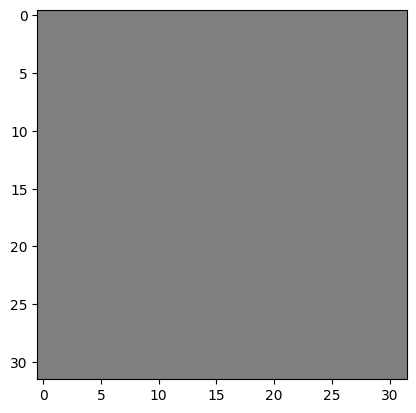

In [10]:
scale_and_display(forwarded_random_image)

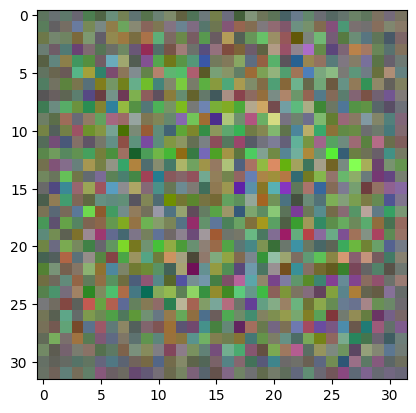

In [11]:
img = forwarded_random_image.permute(0, 2, 3, 1).squeeze().detach().numpy()
maximum = img.max()
minimum = img.min()
scaled_image = (img - minimum) / (maximum - minimum)
plt.imshow(scaled_image)

In [12]:
# Let's ensure that the Discriminator doesn't throw any obvious errors
dis = Discriminator()
dis.forward(forwarded_random_image)

tensor([[0.4988]], grad_fn=<SigmoidBackward0>)

In [13]:
def lambda_scaling(tensor):
    return tensor * 2 - 1

In [14]:
loaded_data = dset.ImageFolder(
    root=".",
    transform=transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Lambda(lambda_scaling),
        ]
    ),
)

In [15]:
data = torch.stack([element[0] for element in loaded_data])
data.shape

torch.Size([975, 3, 32, 32])

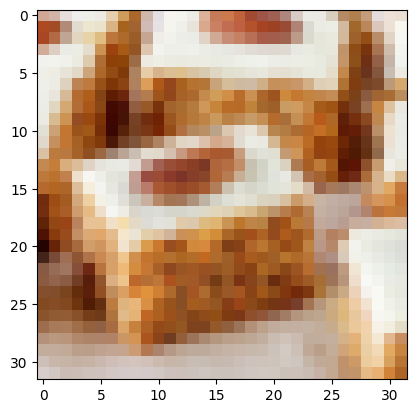

In [16]:
scale_and_display(data[2])

In [17]:
data[0].shape

torch.Size([3, 32, 32])

In [18]:
class NonstandardModel(nn.Module):
    def __init__(self):
        super(NonstandardModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [19]:
my_model = NonstandardModel()
for i, param in enumerate(my_model.parameters()):
    if not i in {0, 3}:  # 0 and 3 correspond to the first 2 fully connected layers
        param.requires_grad = False

In [20]:
# copy model parameters to compare them at the end
reference_list = []
for p in my_model.parameters():
    reference_list.append(torch.clone(p))

In [21]:
batch = torch.stack([get_normal(10) for _ in range(10)])
optimizer = torch.optim.SGD(
    my_model.parameters(), lr=0.001, momentum=0.9, nesterov=True
)
for epoch in range(1000):
    y_pred = my_model(batch)
    loss = -torch.log(42 - 42 * y_pred.mean())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(loss)

tensor(-2.9453, grad_fn=<NegBackward0>)
tensor(-2.9765, grad_fn=<NegBackward0>)
tensor(-3.0147, grad_fn=<NegBackward0>)
tensor(-3.0314, grad_fn=<NegBackward0>)
tensor(-3.0838, grad_fn=<NegBackward0>)
tensor(-3.0451, grad_fn=<NegBackward0>)
tensor(-3.1115, grad_fn=<NegBackward0>)
tensor(-3.1603, grad_fn=<NegBackward0>)
tensor(-3.1492, grad_fn=<NegBackward0>)
tensor(-3.1686, grad_fn=<NegBackward0>)


In [22]:
result_list = []
for p in my_model.parameters():
    result_list.append(p)

for ref, res in zip(reference_list, result_list):
    print((ref - res).sum())

tensor(0.4945, grad_fn=<SumBackward0>)
tensor(0.)
tensor(0.)
tensor(0.7894, grad_fn=<SumBackward0>)
tensor(0.)
tensor(0.)
